In [ ]:
# Use this cell to regroup all your imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config; set_config(display='diagram')

# Import Data

In [ ]:
url = "../data-houses-kaggle-competition/data"
data = pd.read_csv(f'{url}/train.csv', index_col="Id")

data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
data.shape

(1460, 80)

In [ ]:
X = data.drop(columns='SalePrice')
y = data['SalePrice']

X.shape, y.shape

((1460, 79), (1460,))

## Baseline Model

### EDA

In [ ]:
#X.info()

In [ ]:
from sklearn.compose import make_column_selector

cat_col = make_column_selector(dtype_include=['object'])

In [ ]:
feat_categorical_nunique = X[cat_col].nunique()
feat_categorical_nunique.sum()

252

<AxesSubplot:ylabel='Frequency'>

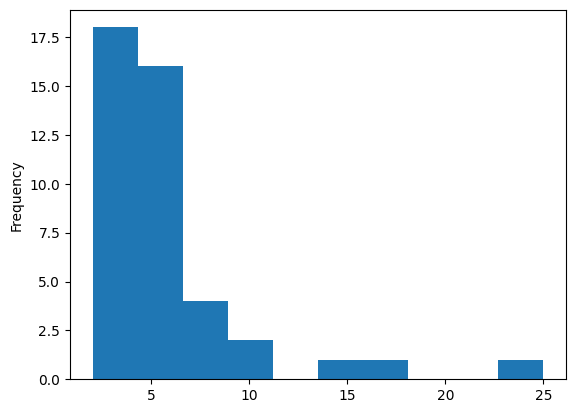

In [ ]:
feat_categorical_nunique.plot.hist()

In [ ]:
feat_categorical_small = list(pd.DataFrame(feat_categorical_nunique[feat_categorical_nunique < 7]).index)
len(feat_categorical_small)

34

### Pipeline

#### Preprocessing

In [ ]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

cat_transformer = make_pipeline(SimpleImputer(strategy = "most_frequent"),
                                OneHotEncoder(handle_unknown='ignore'))


num_transformer = make_pipeline(SimpleImputer(strategy = "mean"), MinMaxScaler())
num_col = make_column_selector(dtype_include=['float64', 'int64'])


preproc_baseline = make_column_transformer((num_transformer, num_col),
                                            (cat_transformer, feat_categorical_small)
                                           )
preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f84dbcadbd0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ign...
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...])])

In [ ]:
pd.DataFrame(preproc_baseline.fit_transform(X)).head()

,0,1,2,3,4,5,6,7,8,9,...,173,174,175,176,177,178,179,180,181,182
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.12250,0.125089,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.00000,0.173281,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.10125,0.086109,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.00000,0.038271,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.21875,0.116052,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
shape_preproc_baseline = pd.DataFrame(preproc_baseline.fit_transform(X)).shape
shape_preproc_baseline

(1460, 183)

#### Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()

pipe_baseline = make_pipeline(preproc_baseline, model)
pipe_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f84dbcadbd0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencod...
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

#### Cross Validation

In [ ]:
pipe_baseline.fit(X,y)

y_pred = pipe_baseline.predict(X)

def func_rmsle(y_pred, y):

    return np.sqrt(np.square(np.log(y + 1) - np.log(y_pred + 1)).mean())

def func_rmsle_neg(y_pred, y):

    return np.sqrt(np.square(np.log(y + 1) - np.log(y_pred + 1)).mean())*(-1)

In [ ]:
from sklearn.metrics import make_scorer

rmsle =  make_scorer(func_rmsle)
rmsle

make_scorer(func_rmsle)

In [ ]:
rmsle_neg = make_scorer(func_rmsle_neg)
rmsle_neg

make_scorer(func_rmsle_neg)

❓5-fold cross-validate your `pipe_baseline` using this metric to get a first glance at your baseline performance.    

Store your mean score as `score_baseline`

In [ ]:
from sklearn.model_selection import cross_val_score

score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring= rmsle).mean()
score_baseline

0.21795052099699425

#### Prediction

In [ ]:
data_test = pd.read_csv(f'{url}/test.csv', index_col="Id")

data_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
index_df = pd.DataFrame(data_test.index)

In [ ]:
y_pred_baseline = pipe_baseline.predict(data_test)
y_pred_baseline

array([129000., 157000., 185000., ..., 142500.,  93500., 192000.])

In [ ]:
pred_df = pd.DataFrame(y_pred_baseline)

In [ ]:
submission = index_df.join(pred_df).set_index("Id")
submission.head()


,0
Id,
1461,129000.0
1462,157000.0
1463,185000.0
1464,178000.0
1465,213500.0


In [ ]:
submission = submission.rename(columns={0: "SalePrice"})

In [ ]:
submission.head()

,SalePrice
Id,
1461,129000.0
1462,157000.0
1463,185000.0
1464,178000.0
1465,213500.0


In [ ]:
submission.to_csv(f'{url}/submission_baseline.csv')

## Decision Tree Regressor

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('preprocessing', preproc_baseline),
    ('model', DecisionTreeRegressor())
])

pipe.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('minmaxscaler',
                                                     MinMaxScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f84dbcadbd0>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ign...
                                    ['MSZoning', 'Street', 'Alley', 'LotShape',
                                     'LandCon

In [ ]:
X = data.drop(columns='SalePrice')
y = data['SalePrice']

search = GridSearchCV(pipe,
    param_grid={'model__min_samples_leaf': [1, 2, 4, 6, 8, 10],
               'model__min_samples_split': [1, 2, 4, 6, 8, 10]},
    cv=5,
    scoring=rmsle,
    n_jobs=-1)



search.fit(X,y)

search.best_score_

0.2148532450784006

## Random Forest Regressor

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

pipe2 = Pipeline([
    ('preprocessing', preproc_baseline),
    ('model', RandomForestRegressor())
])

pipe2.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('minmaxscaler',
                                                     MinMaxScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f84dbcadbd0>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ign...
                                    ['MSZoning', 'Street', 'Alley', 'LotShape',
                                     'LandCon

In [ ]:
X = data.drop(columns='SalePrice')
y = data['SalePrice']

search2 = GridSearchCV(pipe2,
    param_grid={'model__min_samples_leaf': [1,2,3],
               'model__min_samples_split': [1,2,3],
               'model__n_estimators': [100]},
    cv=5,
    scoring=rmsle,
    n_jobs=-1)

search2.fit(X,y)

search2.best_score_

0.1477267849249932

In [ ]:
random_forest_params = search2.best_estimator_
random_forest_params

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f85513c3cd0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',...
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('model',
                 RandomForestRegressor(min_samples_leaf=2,
                                       min_samples_split=1))])

## Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor()


pipe3 = Pipeline([
    ('preprocessing', preproc_baseline),
    ('model', model)
])

pipe3.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('minmaxscaler',
                                                     MinMaxScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f84dbcadbd0>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ign...
                                    ['MSZoning', 'Street', 'Alley', 'LotShape',
                                     'LandCon

In [ ]:
X = data.drop(columns='SalePrice')
y = data['SalePrice']

search3 = GridSearchCV(pipe3,
    param_grid={'model__max_depth': [3,4],
               'model__learning_rate': [0.1,0.2],
               'model__n_estimators': [100]},
    cv=5,
    scoring=rmsle,
    n_jobs=-1)

search3.fit(X,y)

search3.best_score_

0.13531091502848824

In [ ]:
gradient_boosting_params = search3.best_estimator_
gradient_boosting_params

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f84daeb2620>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',...
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('model', GradientBoostingRegressor(learning_rate=0.2))])

## XGB Regressor

In [ ]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor()


pipe4 = Pipeline([
    ('preprocessing', preproc_baseline),
    ('model', xgb_reg)
])


X = data.drop(columns='SalePrice')
y = data['SalePrice']

search4 = GridSearchCV(pipe4,
    param_grid={'model__max_depth': [3,4,5],
               'model__learning_rate': [0.1,0.2],
               'model__n_estimators': [100]},
    cv=5,
    scoring=rmsle,
    n_jobs=-1)

search4.fit(X,y)

search4.best_score_

0.13462077599201672

In [ ]:
xg_boosting_params = search4.best_estimator_
xg_boosting_params

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8546aa48b0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',...
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=4, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

In [ ]:
xg_boosting_params

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8546aa48b0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',...
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=4, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])

In [ ]:
preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f84dbcadbd0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ign...
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...])])

In [ ]:
xg_boosting_params.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('minmaxscaler',
                                                     MinMaxScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f8546aa48b0>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ign...
                                    ['MSZoning', 'Street', 'Alley', 'LotShape',
                                     'LandCon

## Stacking Regressor

In [ ]:
from sklearn.ensemble import StackingRegressor


ensemble = StackingRegressor(estimators = [("rf", RandomForestRegressor(min_samples_leaf=2, min_samples_split=1)),
("gr", GradientBoostingRegressor(learning_rate=0.2))],

final_estimator = XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
              reg_lambda=1))

ensemble


pipe5 = Pipeline([
    ('preprocessing', preproc_baseline),
    ('model', ensemble)
])

pipe5

score_baseline_stacking = cross_val_score(pipe5, X, y, cv=5, scoring= rmsle).mean()

score_baseline_stacking

0.14385522774350387

In [ ]:
pipe5

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f84dbcadbd0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',...
                                                                gamma=0,
                                                                gpu_id=-1,
                                                                grow_policy='depthwise',
                                                                importance_type=None,
                                                                interaction_constraints='',
                                                                learning_rate=0.1,
                                                                max_bin=256,
                                                                max_cat_to_onehot=4,
                                                                max_delta_step=0,
                                                                max_depth=4,
                                                                max_leaves=0,
                                                                min_child_weight=1,
                                                                missing=nan,
                                                                monotone_constraints='()',
                                                                n_estimators=100,
                                                                n_jobs=0,
                                                                num_parallel_tree=1,
                                                                predictor='auto',
                                                                random_state=0,
                                                                reg_alpha=0,
                                                                reg_lambda=1, ...)))])

# Final Model

In [ ]:
test_score = score_baseline_stacking
test_score

0.14385522774350387

In [ ]:
pipe5.fit(X,y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f84dbcadbd0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',...
                                                                gamma=0,
                                                                gpu_id=-1,
                                                                grow_policy='depthwise',
                                                                importance_type=None,
                                                                interaction_constraints='',
                                                                learning_rate=0.1,
                                                                max_bin=256,
                                                                max_cat_to_onehot=4,
                                                                max_delta_step=0,
                                                                max_depth=4,
                                                                max_leaves=0,
                                                                min_child_weight=1,
                                                                missing=nan,
                                                                monotone_constraints='()',
                                                                n_estimators=100,
                                                                n_jobs=0,
                                                                num_parallel_tree=1,
                                                                predictor='auto',
                                                                random_state=0,
                                                                reg_alpha=0,
                                                                reg_lambda=1, ...)))])

In [ ]:
y_pred_baseline_final = pipe5.predict(data_test)
y_pred_baseline_final

array([118402.5 , 156206.78, 179634.67, ..., 165340.84, 114941.69,
       242201.1 ], dtype=float32)

In [ ]:
prediction_df = pd.DataFrame(y_pred_baseline_final)

In [ ]:
submission_final = index_df.join(prediction_df).set_index("Id")
submission_final.head()

,0
Id,
1461,118402.500000
1462,156206.781250
1463,179634.671875
1464,184010.828125
1465,182484.640625


In [ ]:
submission_final = submission_final.rename(columns={0: "SalePrice"})
submission_final.head()

,SalePrice
Id,
1461,118402.500000
1462,156206.781250
1463,179634.671875
1464,184010.828125
1465,182484.640625


In [ ]:
submission_final.to_csv(f'{url}/submission_baseline_final.csv')